## Leveraging Dask for timeseries sampling

When loading timeseries selections that would be too large to fit in memory, or to speed up timeseries slicing, you can leverage dask to return lazy arrays to napari to point to yt datasets of a timeseries. The two relevant parameters to `yt_napari.timeseries.add_to_viewer()` are `use_dask` and `return_delayed`. 

But first, we'll spin up a dask client. 

As a side note -- `yt` is generally not guaranteed to be threadsafe. But in practice, the sampling in `yt_napari` does tend to be thread safe as long as you disable `yt`'s logging, which `timeseries.add_to_viewer` does internally. 

With that said, we'll spin up a dask client with 5 workers and 5 threads per worker:

In [2]:
from dask.distributed import Client 

In [4]:
c = Client(n_workers=5, threads_per_worker=5)

In [5]:
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 25,Total memory: 31.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35003,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 25
Started: Just now,Total memory: 31.18 GiB
Comm: tcp://127.0.0.1:35913,Total threads: 5
Dashboard: http://127.0.0.1:35249/status,Memory: 6.24 GiB
Nanny: tcp://127.0.0.1:33663,


and let's import our packages and initialize a napari viewer:

In [6]:
import napari 
from yt_napari import timeseries
v = napari.Viewer()

## Delayed image stacks 

When supplying `use_dask`, it is recommended that you also use `load_as_stack`, which results in a napari image layer where only the active slice is loaded in memory. Note that it's good to provide the `contrast_limits` here as well so that the image is normalized across timesteps. 

For 2D slices:

In [11]:
%%capture
slc = timeseries.Slice(("enzo", "Density"), "x", resolution=(800, 800))
file_pattern = "enzo_tiny_cosmology/DD????/DD????"
timeseries.add_to_viewer(v, slc, file_pattern=file_pattern, load_as_stack=True, 
                         use_dask=True, 
                         contrast_limits=(-1, 2),
                         colormap = 'magma',
                         name="Lazy density")

Parsing Hierarchy : 100%|██████████| 120/120 [00:00<00:00, 17126.02it/s]


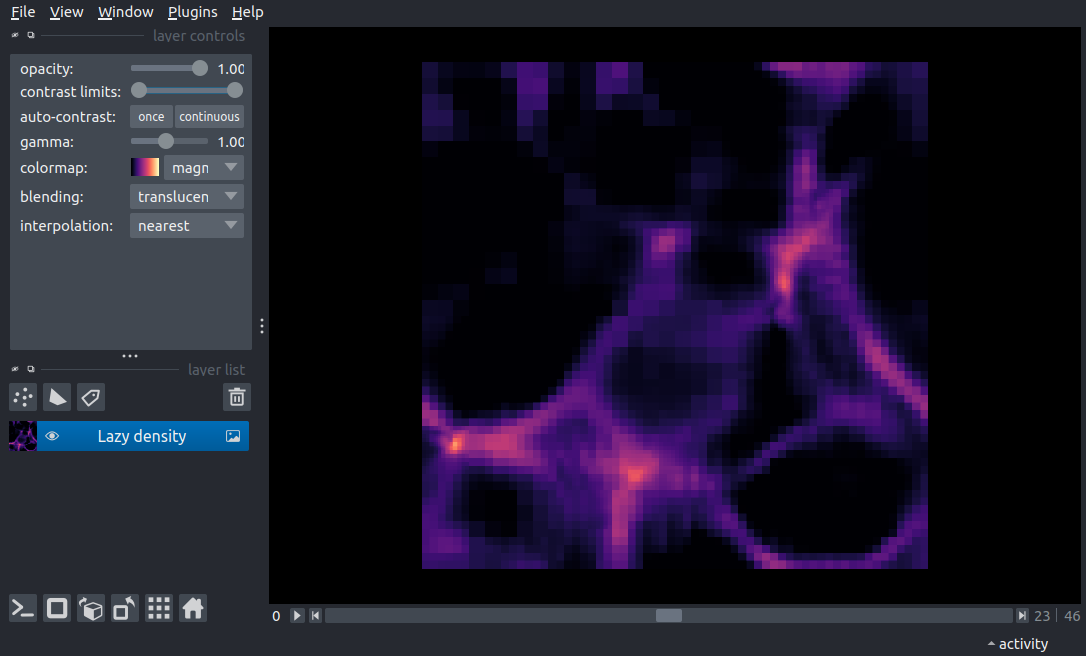

In [12]:
from napari.utils import nbscreenshot
nbscreenshot(v)

Now, as you drag the slider through, each timestep will be loaded on demand. While this adds a few seconds of processing time, it does allow you to load data that would not fit fully into memory. While less of a problem for slices, the following demonstrates a case that would result in an array roughly 22 Gb in size when loaded in memory:

In [19]:
%%capture
reg = timeseries.Region(("enzo", "Density"), resolution=(400, 400, 400))
v.layers.clear()
timeseries.add_to_viewer(v, reg, file_pattern=file_pattern, load_as_stack=True, 
                         use_dask=True, 
                         contrast_limits=(-1, 2),
                         colormap='magma',
                         name='Lazy region',)
v.dims.ndisplay = 3

Parsing Hierarchy : 100%|██████████| 214/214 [00:00<00:00, 6973.94it/s]


and now clicking through timesteps loads a new 3D region on demand:

![](./resources/yt_napari_timeseries_regdask_vid.gif)

## Using dask, returning in-memory image array 

Finally, for the case where you **can** fit the whole image array in memory, you can set `returned_delayed` to False and dask will be used to fetch the selections. This works best for slices, where you **probably** can safely fit all those slices in memory. 

In [21]:
%%time
slice = timeseries.Slice(("enzo", "Density"), "x", resolution=(1600, 1600))
v.layers.clear()
v.dims.ndisplay = 2
timeseries.add_to_viewer(v, slice, file_pattern=file_pattern, load_as_stack=True, 
                         use_dask=True, 
                         return_delayed = False,
                         contrast_limits=(-1, 2),
                         colormap='magma', 
                         name='Density stack')

Parsing Hierarchy : 100%|██████████| 2/2 [00:00<00:00, 5349.88it/s]

Parsing Hierarchy : 100%|██████████| 66/66 [00:00<00:00, 17745.13it/s]]

Parsing Hierarchy : 100%|██████████| 196/196 [00:00<00:00, 3391.56it/s]

Parsing Hierarchy : 100%|██████████| 188/188 [00:00<00:00, 4992.37it/s]


CPU times: user 1.11 s, sys: 800 ms, total: 1.91 s
Wall time: 12.1 s


and we've taken our ~30s selection time down to ~12s.

In [22]:
c.close()